All instructions are provided for R. I am going to reproduce them in Python as best as I can.

# Preface

From the textbook, p. 122:
> This question involves the use of multiple linear regression on the
`Auto` data set.

In [106]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms


sns.set()
%matplotlib inline

In [107]:
auto = pd.read_csv('https://www.statlearning.com/s/Auto.csv', index_col=0)
auto = auto[auto != '?'].dropna().reset_index()
auto.horsepower = auto.horsepower.astype(np.int16)
auto.origin = auto.origin.astype('category')
auto.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite


Columns:
1. `mpg` &mdash; miles per gallon.
1. `cylinders` &mdash; number of cylinders between 4 and 8.
1. `displacement` &mdash; engine displacement (cu. inches).
1. `horsepower` &mdash; engine horsepower.
1. `weight` &mdash; vehicle weight (lbs.).
1. `acceleration` &mdash; time to accelerate from 0 to 60 mph (sec.).
1. `year` &mdash; model year (modulo 100).
1. `origin` &mdash; origin of car (1. American, 2. European, 3. Japanese)
1. `name` &mdash; vehicle name.

# (a)

From the textbook, p. 122:
> Produce a scatterplot matrix which includes all of the variables
in the data set.

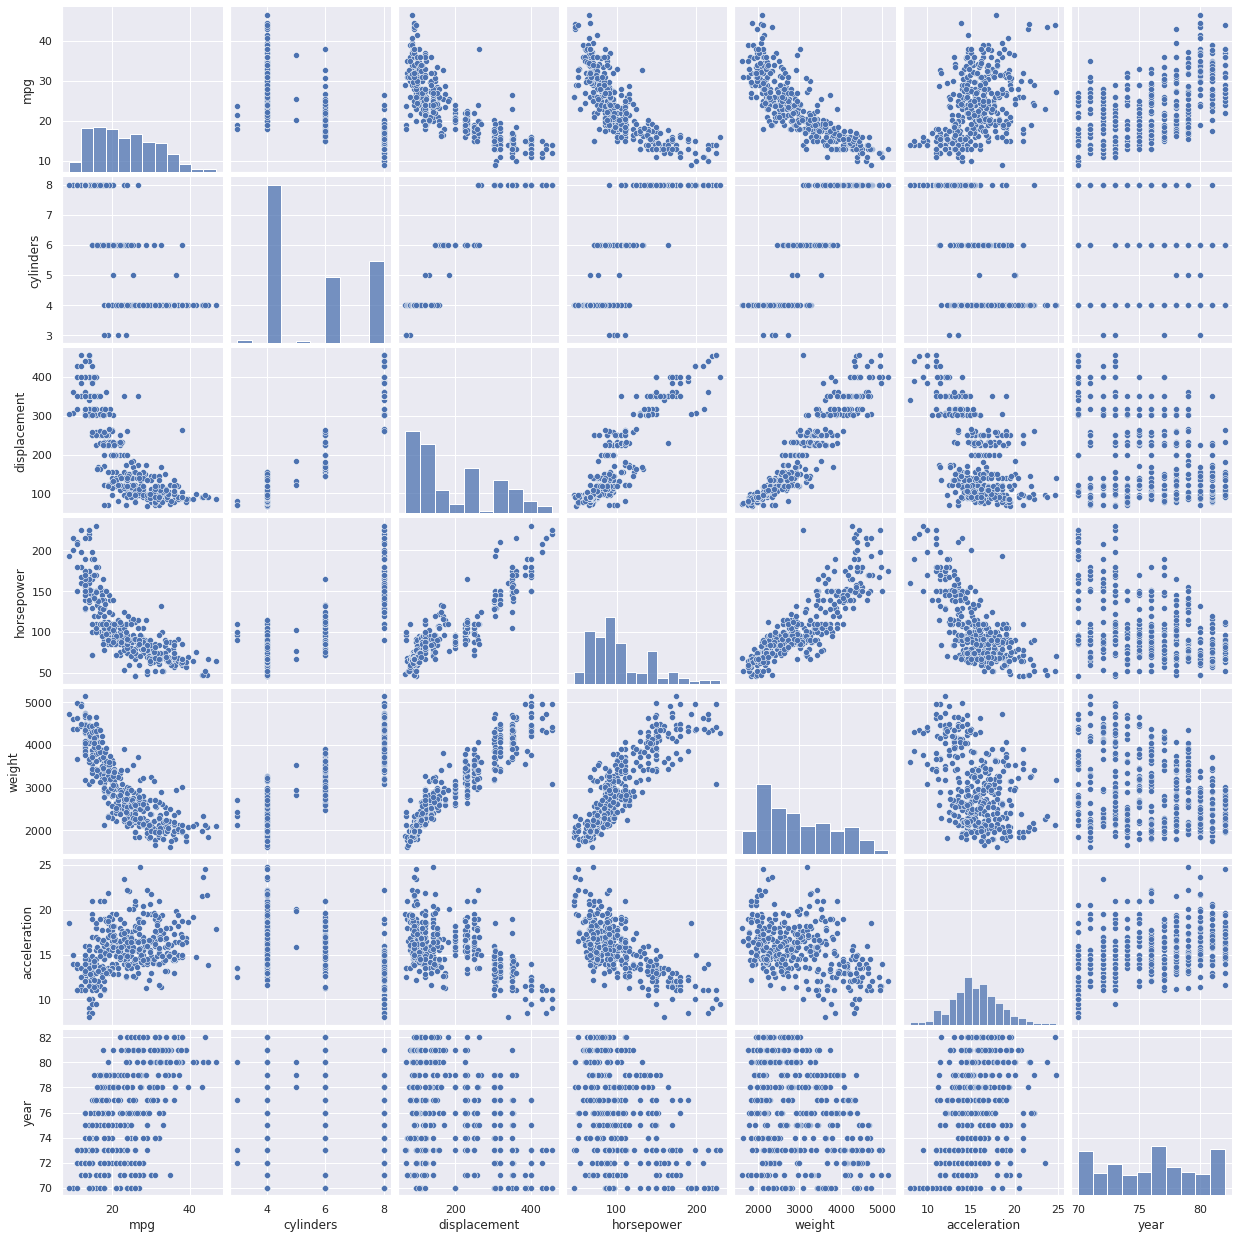

In [108]:
sns.pairplot(auto.drop('name', axis='columns'))

# (b)

From the textbook, p. 122:
> Compute the matrix of correlations between the variables using
the function `cor()`. You will need to exclude the name variable, which is qualitative.

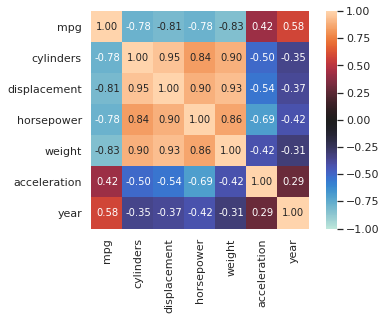

In [109]:
sns.heatmap(auto.corr()
            , vmin=-1
            , vmax=1
            , annot=True
            , fmt='.2f'
            , square=True
            , cmap=sns.color_palette('icefire', as_cmap=True))
plt.show()

There are a bunch of correlated variables.

# (c)

From the textbook, p. 122:
> Use the `lm()` function to perform a multiple linear regression
with `mpg` as the response and all other variables except `name` as
the predictors. Use the `summary()` function to print the results.

Before I do anything, I need to create dummy variables for `origin` and add columns of interactions.
<a name="model_summary"></a>

In [110]:
x = auto.drop(['mpg', 'name', 'origin'], axis='columns')
x['is_american'] = 0
x.loc[auto.origin == 1, 'is_american'] = 1
x['is_european'] = 0
x.loc[auto.origin == 2, 'is_european'] = 1

predictors = x.columns.to_list()
# Add interactions:
interactions = []
for p1 in predictors:
  for p2 in predictors:
    if p1 < p2:
      interaction = f'{p1}:{p2}'
      x[interaction] = x[p1] * x[p2]
      interactions.append(interaction)

x['intercept'] = 1
predictors.append('intercept')
y = auto.mpg

model = sm.regression.linear_model.OLS(y, x[predictors]).fit(use_t=True)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     224.5
Date:                Fri, 09 Apr 2021   Prob (F-statistic):          1.79e-139
Time:                        22:21:40   Log-Likelihood:                -1020.5
No. Observations:                 392   AIC:                             2059.
Df Residuals:                     383   BIC:                             2095.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
cylinders       -0.4897      0.321     -1.524   

> Comment on the output. For instance:<br>
  i. Is there a relationship between the predictors and the response?

P-value of the F-test is 1.79e-139. There is a relationship between the response and at least one of the predictors.

> ii. Which predictors appear to have a statistically significant
relationship to the response?

`displacement`, `weight`, `year`, `is_american` (in the for of its dummy variables) &mdash; all have low p-values for their t-tests.

> iii. What does the coefficient for the year variable suggest?

With each new year, car fuel efficiency increases by 0.777 miles per gallon.

# (d)

From the textbook, p. 122:
> Use the `plot()` function to produce diagnostic plots of the linear
regression fit.

I am going to copy-paste a fragment from the previous exercise, where I reproduced R's `plot(<fitted_linear_model>)` function.

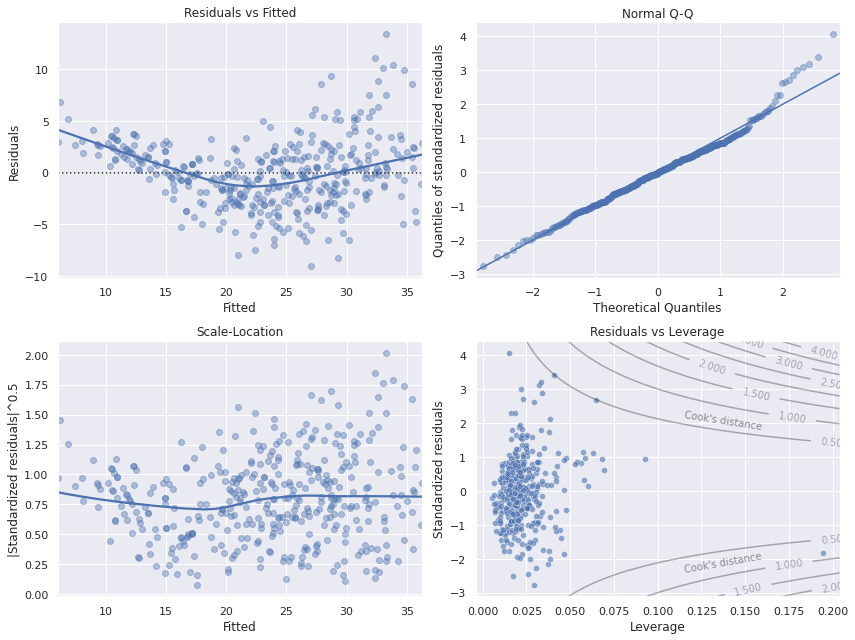

In [111]:
def lm_plot(lm_fit, levels=None):
  """
  Replicates R's diagnostic plots for a linear model.

  Arguments:
  lm_fit: a fitted OLS model from statsmodels.
  levels: levels of contour lines.

  Returns:
  fig, axs: matplotlib subplots on a 2 by 2 grid.
  The plots are:
    - residual plot;
    - Q-Q plot for model's standardized residuals;
    - scale-location plot;
    - leverage plot (also called influence plot).
  """

  fitted = lm_fit.fittedvalues
  influence = lm_fit.get_influence()
  leverage = influence.hat_matrix_diag
  residuals = lm_fit.resid
  standardized_residuals =  influence.resid_studentized_internal

  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))

  # 1. Upper-left: Residual plot
  sns.residplot(x=fitted
                , y=residuals
                , lowess=True
                , scatter_kws={'alpha' : 0.4}
                , ax=axs[0, 0]
              )
  axs[0, 0].set_title('Residuals vs Fitted')
  axs[0, 0].set_xlabel('Fitted')
  axs[0, 0].set_ylabel('Residuals')

  # 2. Upper-right: Q-Q plot
  sm.qqplot(standardized_residuals, ax=axs[0, 1], alpha=0.4)
  sm.graphics.abline_plot(0, 1, ax=axs[0, 1])
  axs[0, 1].set_title('Normal Q-Q')
  axs[0, 1].set_ylabel('Quantiles of standardized residuals')

  # 3. Bottom-left: Scale-location plot
  sns.regplot(x=fitted
              , y=np.abs(standardized_residuals)**0.5
              , lowess=True
              , scatter_kws={'alpha' : 0.4}
              , ax=axs[1, 0]
            )
  axs[1, 0].set_xlabel('Fitted')
  axs[1, 0].set_ylabel('|Standardized residuals|^0.5')
  axs[1, 0].set_title('Scale-Location')

  # 4. Bottom-right: Leverage plot
  axs[1, 1].set_title('Residuals vs Leverage')
  axs[1, 1].set_xlabel('Leverage')
  axs[1, 1].set_ylabel('Standardized residuals')
  sns.scatterplot(x=leverage
              , y=standardized_residuals
              , alpha=0.6
              , ax=axs[1, 1]
            )
  
  l_min, l_max = axs[1, 1].get_xlim()
  leverage_range = np.linspace(l_min, l_max, num=1000)
  sr_min, sr_max = axs[1, 1].get_ylim()
  st_residuals_range = np.linspace(sr_min, sr_max, num=1000)

  leverage, st_residuals = np.meshgrid(leverage_range, st_residuals_range)
  cooks_distance = st_residuals**2 * leverage / (1 - leverage)

  cs = axs[1, 1].contour(leverage
                        , st_residuals
                        , cooks_distance
                        , alpha=0.3
                        , colors='black'
                        , levels=levels
                        )
  axs[1, 1].clabel(cs, inline=True, fontsize=10)
  return fig, axs

fig, axs = lm_plot(model, [0.5, 1, 1.5, 2, 2.5, 3.0, 3.5, 4.0])
axs[1, 1].annotate("Cook's distance", [0.115, 1.8], alpha=0.5, rotation=-9.0)
axs[1, 1].annotate("Cook's distance", [0.115, -2.4], alpha=0.5, rotation=10.0)

plt.tight_layout()
plt.show()

> Comment on any problems you see with the fit.

1. The U-shaped pattern seen on the residual plot suggests that there is non-linearity unexplained by the model.
1. Distribution of standardized residuals seem to strongly deviate from Gaussian. With p-value of 3.30e-08, Jarque-Bera's test (see the [summary](#model_summary)) for normality suggests the same.
1. I think the relationship is heteroscedastic. The three tests [offered](https://www.statsmodels.org/stable/diagnostic.html#heteroscedasticity-tests) by `statsmodels`.

In [112]:
# I am printing out only the p-value.
print(
    sms.diagnostic.het_breuschpagan(model.resid
                                    , x[['intercept', 'horsepower']]
                                   )[1],
    sms.diagnostic.het_white(model.resid
                             , x[['intercept', 'horsepower']]
                            )[1],
    sms.diagnostic.het_white(y, x[['intercept', 'horsepower']])[1]
)

0.003798201197468817 5.806502871664099e-05 2.24333746612765e-53


Those p-values won't lie.<br><br>

> Do the residual plots suggest any unusually large outliers?

I don't think so.

> Does the leverage plot identify any observations with unusually high
leverage?

It does! I see three points with high influence: two have Cook's distance of 0.5, another one has Cook's distance close to 1.

# (e)

From the textbook, p. 122:
> Use the `*` and `:` symbols to fit linear regression models with
interaction effects. Do any interactions appear to be statistically
significant?

Let's go crazy here and add add possible pairs of predictors.

In [113]:
model_aug = sm.regression.linear_model.OLS(y, x[predictors + interactions])
model_aug = model_aug.fit(use_t=True)
print(model_aug.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     88.34
Date:                Fri, 09 Apr 2021   Prob (F-statistic):          1.74e-153
Time:                        22:21:43   Log-Likelihood:                -916.16
No. Observations:                 392   AIC:                             1904.
Df Residuals:                     356   BIC:                             2047.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
cylinders             

$R^2$ is high (the model fits well, technically), but p-values for the predictors (both individual and interactions) are terrible. I can see, that `acceleration:cylinders`, `acceleration:year`, `acceleration:is_american` are statistically significant at alpha-level of 5%. At this point, it is hard to understand what I should keep. I could not find any implementations of feature selection methods in `statsmodels`. 

## *Feature selection in Scikit Learn* side-quest

For the purposes of feature selection in this exercise, I am ditching the linear model from `statsmodels` and use the one in Scikit-learn. I am trying to use [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html).

**Disclaimer:** I have no idea what I am doing.

In [114]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression


selector = RFECV(step=1, cv=5, estimator=LinearRegression()).fit(x.values, y.values)
best_predictors = (
  x.columns.to_numpy()[
                       np.where(
                                 selector.get_support()
                               )[0]
                      ]
)

model_aug = sm.regression.linear_model.OLS(y, x[best_predictors]).fit(use_t=True)
print(model_aug.summary())

                                 OLS Regression Results                                
Dep. Variable:                    mpg   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              1155.
Date:                Fri, 09 Apr 2021   Prob (F-statistic):                        0.00
Time:                        22:21:43   Log-Likelihood:                         -924.40
No. Observations:                 392   AIC:                                      1907.
Df Residuals:                     363   BIC:                                      2022.
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

This is interesting. Notes:
1. The $R^2$ is very high.
1. A lot of regressors have statistical significance.
1. There is no intercept. [This thread](https://stats.stackexchange.com/questions/7948/when-is-it-ok-to-remove-the-intercept-in-a-linear-regression-model) on StackOverflow says that this is most likely incorrect.

Let's try fitting the model with the same predictors + the intercept.

In [115]:
model_aug = sm.regression.linear_model.OLS(y, x[list(best_predictors) + ['intercept']]).fit(use_t=True)
print(model_aug.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     103.5
Date:                Fri, 09 Apr 2021   Prob (F-statistic):          3.09e-156
Time:                        22:21:43   Log-Likelihood:                -924.37
No. Observations:                 392   AIC:                             1909.
Df Residuals:                     362   BIC:                             2028.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
cylinders             

$R^2$ has dropped significantly. There are quite a few variables that have statistical significance, according to the summary (alpha-level is 1%): `weight`, `is_american`, `cylinders:displacement`, `acceleration:cylinders`, `acceleration:is_american`, `is_american:year`. Let's see if I will have any luck fitting linear regression with just those.

**Note:** the textbook mentions the *hierarchical rule*, according to which I am required to include the main effects (separate variables) of the interactions.

In [116]:
# I did just what I've just said above + commented out all variables with high
# p-values.

significant_predictors = [
  'acceleration',
  #'cylinders',
  'year',
  'weight',
  'is_american',
  #'cylinders:displacement',
  #'acceleration:cylinders',
  'acceleration:is_american',
  'is_american:year',
  'intercept',
]
model_significant = sm.regression.linear_model.OLS(y, x[significant_predictors]).fit(use_t=True)
print(model_significant.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     357.0
Date:                Fri, 09 Apr 2021   Prob (F-statistic):          6.77e-154
Time:                        22:21:43   Log-Likelihood:                -992.41
No. Observations:                 392   AIC:                             1999.
Df Residuals:                     385   BIC:                             2027.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
acceleration            

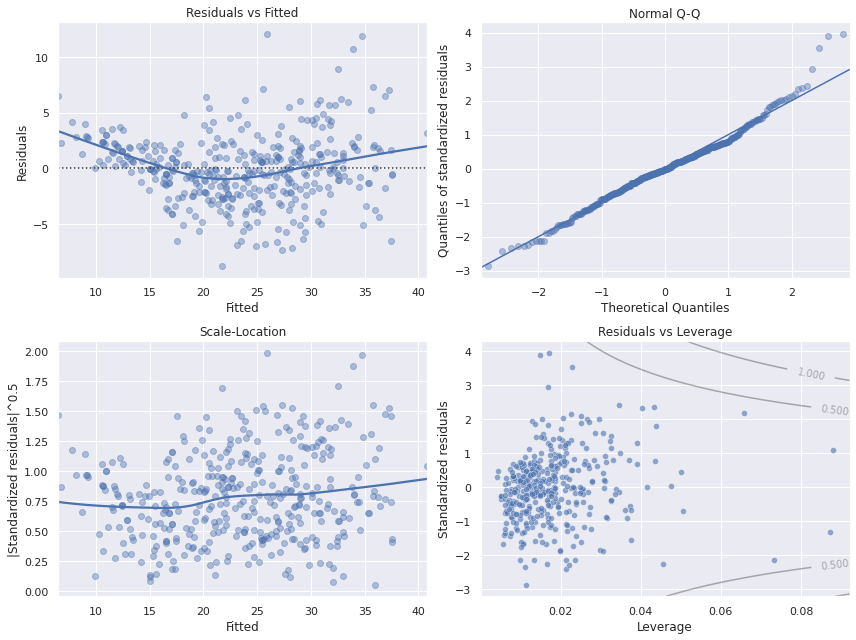

In [117]:
lm_plot(model_significant, [0.5, 1])
plt.tight_layout()

Well, if you pay attention only to $R^2$ and p-values of individual predictors, I've done a good job selecting features.

The pruned model also seem to have a benefit of being homoscedastic (as far as I can tell by the plot).

## Finally, the answer to the question I have been asked

> Use the `*` and `:` symbols to fit linear regression models with
interaction effects. Do any interactions appear to be statistically
significant?

`acceleration:is_american`, `is_american:year` appear to be statistically
significant.

# (f)

From the textbook, p. 122:
> Try a few different transformations of the variables, such as $ \log(X), \; \sqrt{X}, \; X^2$. Comment on your findings.

I am continuing with the pruned model from the previuos step.

In [134]:
significant_predictors = [
  'acceleration',
  'year',
  'weight',
  'is_american',
  'acceleration:is_american',
  'is_american:year',
  'intercept',
]

log_pred = []
sqrt_pred = []
squared_pred = []
for p in ['acceleration', 'year', 'weight']:
  x[f'log({p})'] = np.log(x[p])
  log_pred.append(f'log({p})')
  x[f'sqrt({p})'] = np.sqrt(x[p])
  sqrt_pred.append(f'sqrt({p})')
  x[f'{p}2'] = x[p]**2
  squared_pred.append(f'{p}2')

pred = (significant_predictors
        #+ log_pred
        #+ sqrt_pred
        + squared_pred
)

selector = RFECV(step=1, cv=5, estimator=LinearRegression()).fit(x[pred].values, y.values)
best_predictors = (
  np.array(pred)[
                       np.where(
                                 selector.get_support()
                               )[0]
                      ]
)

model_aug = sm.regression.linear_model.OLS(y, x[significant_predictors]).fit(use_t=True)
print(model_aug.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     357.0
Date:                Fri, 09 Apr 2021   Prob (F-statistic):          6.77e-154
Time:                        22:35:39   Log-Likelihood:                -992.41
No. Observations:                 392   AIC:                             1999.
Df Residuals:                     385   BIC:                             2027.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
acceleration            

I've had some luck with squares.

In [135]:
significant_predictors = [
  'acceleration',
  'year',
  'weight',
  'is_american',
  'acceleration:is_american',
  'is_american:year',
  'intercept',
  'year2',
  'weight2'
]

model_aug = sm.regression.linear_model.OLS(y, x[significant_predictors]).fit(use_t=True)
print(model_aug.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     349.3
Date:                Fri, 09 Apr 2021   Prob (F-statistic):          8.91e-171
Time:                        22:35:44   Log-Likelihood:                -946.49
No. Observations:                 392   AIC:                             1911.
Df Residuals:                     383   BIC:                             1947.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
acceleration            

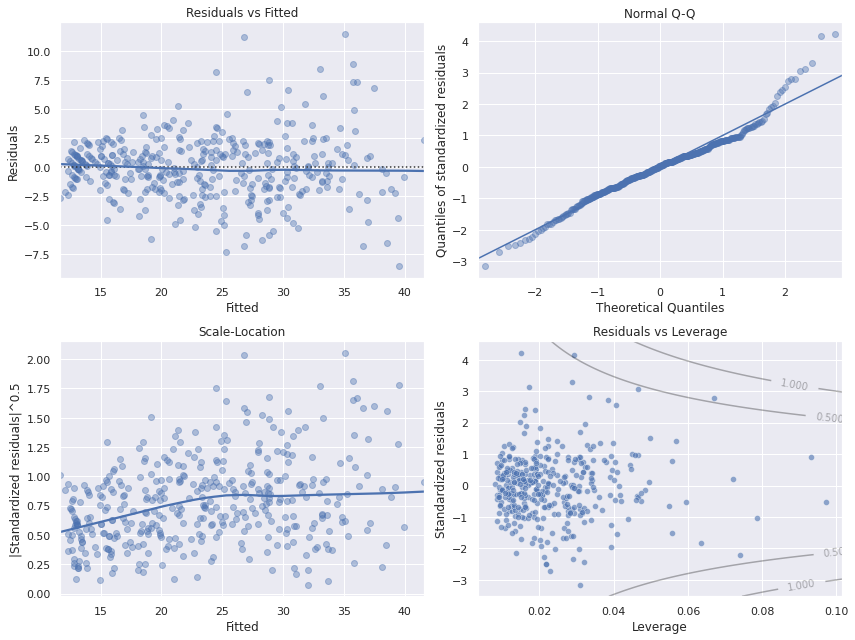

In [136]:
lm_plot(model_aug, [0.5, 1])
plt.tight_layout()

Looks like this has addressed the non-linearity.